# Install and import libraries

In [ ]:
!pip install accelerate
!pip install flash_attn einops timm

In [ ]:
import textwrap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageDraw, ImageFont
from transformers import AutoProcessor, AutoModelForCausalLM


# Import Florence-2 model

In [ ]:
device = 'cpu' #'gpu'

model_id = 'microsoft/Florence-2-base'

#load Florence-2 model
model = AutoModelForCausalLM.from_pretrained(model_id, device_map = device, trust_remote_code=True).eval()

processor = AutoProcessor.from_pretrained(model_id, device_map = device, trust_remote_code=True)

# Load input images

In [ ]:
img1 = Image.open('img-1.jpg')
img2 = Image.open('img-2.jpg')
img3 = Image.open('img-3.jpg')

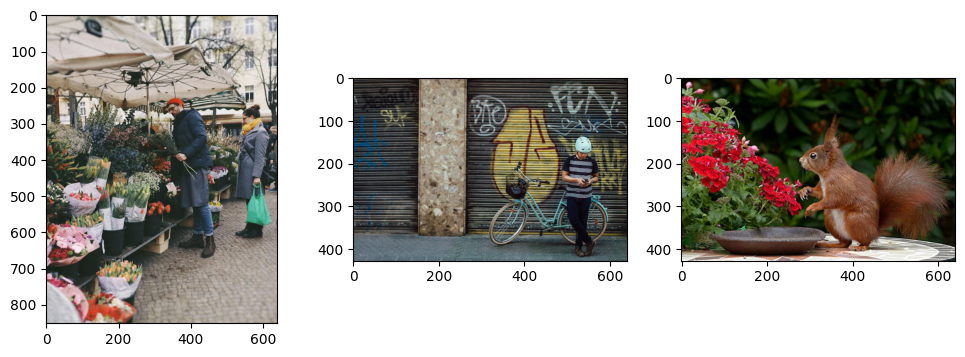

In [ ]:
# display multiple images
rows, cols = 1, 3

plt.figure(figsize=(12, 4))

plt.subplot(rows, cols, 1)
plt.imshow(img1)

plt.subplot(rows, cols, 2)
plt.imshow(img2)

plt.subplot(rows, cols, 3)
plt.imshow(img3)

plt.show()

In [ ]:
def generate_labels(task_prompt, image, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input

    inputs = processor(text=prompt, images=image, return_tensors="pt").to(device)

    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )

    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    output = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return output

# Task 1 - Image captioning

In [ ]:
task_prompt = '<CAPTION>'

caption1 = list(generate_labels(task_prompt, img1).values())[0]
caption2 = list(generate_labels(task_prompt, img2).values())[0]
caption3 = list(generate_labels(task_prompt, img3).values())[0]

A couple of people standing next to a bunch of flowers.


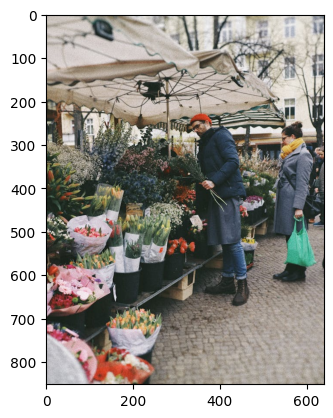

In [ ]:
print(caption1)
plt.imshow(img1);

a man standing next to a bike with graffiti on it


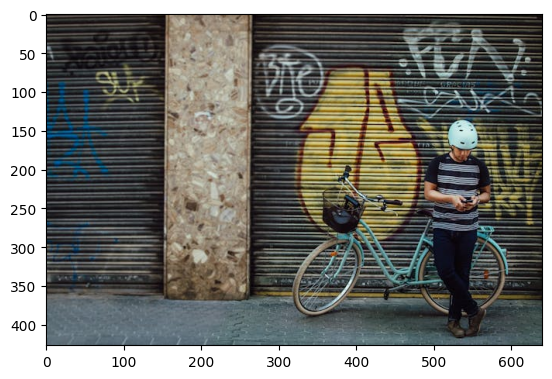

In [ ]:
print(caption2)
plt.imshow(img2);

A red squirrel standing on its hind legs next to a bowl of flowers.


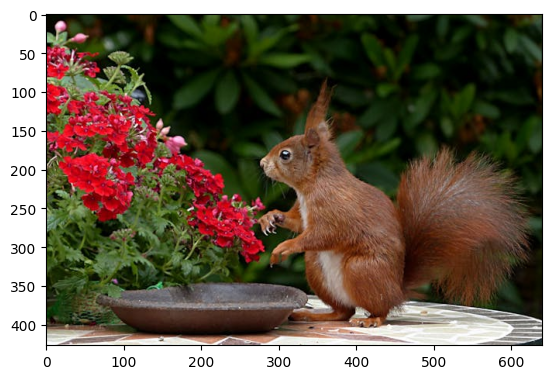

In [ ]:
print(caption3)
plt.imshow(img3);

# Task 2 - Image description generation

In [ ]:
task_prompt2 = '<MORE_DETAILED_CAPTION>'

long_caption1 = list(generate_labels(task_prompt2, img1).values())[0]
long_caption2 = list(generate_labels(task_prompt2, img2).values())[0]
long_caption3 = list(generate_labels(task_prompt2, img3).values())[0]

The image shows a man and a woman at a flower market. The man is
wearing a blue coat and a red beanie, and is holding a bunch of
flowers in his hands. He is standing in front of a table with multiple
rows of flower pots filled with different types of flowers. The table
is covered with a white canopy, and there are trees and buildings in
the background. The woman is standing next to the table, wearing a
gray coat and carrying a green shopping bag. Both the man and the
woman appear to be looking at the flowers.


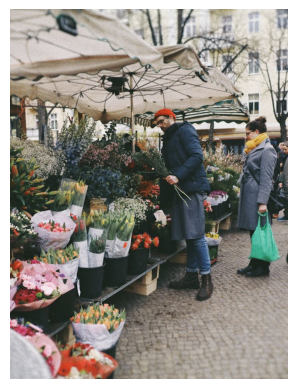

In [ ]:
print('\n'.join(textwrap.wrap(long_caption1)))

plt.imshow(img1);
plt.axis('off');

The image shows a man standing next to a blue bicycle on a street. He
is wearing a white helmet and a black and white striped shirt. The
bicycle has a basket attached to the front and appears to be a vintage
model. The man is looking at his phone and seems to be engrossed in
it. Behind the man, there is a large garage door with graffiti on it.
The graffiti is in various colors and styles, including red, yellow,
and blue. The garage door is made of corrugated metal and has a rough
texture. The street is empty, with no other people or buildings
visible in the background.


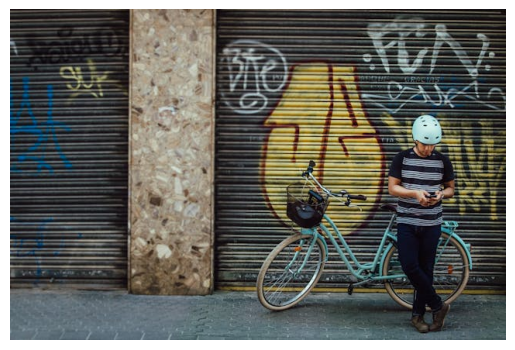

In [ ]:
print('\n'.join(textwrap.wrap(long_caption2)))

plt.imshow(img2)
plt.axis('off');

The image shows a red squirrel standing on its hind legs on a tiled
table in a garden. The squirrel is facing towards the right side of
the image and is holding a small bird feeder in its paws. It has a
bushy tail and bushy ears. In front of the squirrel, there is a potted
plant with red flowers and green leaves. The background is blurred,
but it appears to be a garden with other plants and flowers.


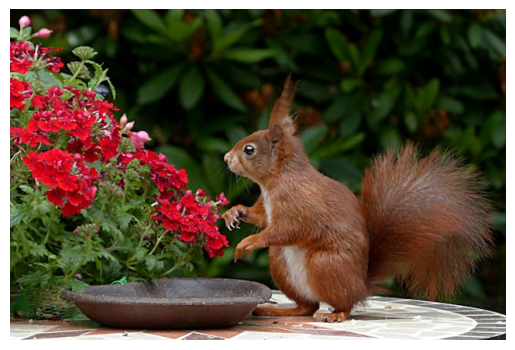

In [ ]:
print('\n'.join(textwrap.wrap(long_caption3)))

plt.imshow(img3);
plt.axis('off');

# Task 3 - Object Detection

In [ ]:
task_prompt3 = '<OD>'
results1 = generate_labels(task_prompt3, img1)

In [ ]:
results1['<OD>']

{'bboxes': [[0.3199999928474426,
   0.4259999990463257,
   639.0399780273438,
   316.51800537109375],
  [340.79998779296875,
   254.32200622558594,
   466.239990234375,
   534.6300048828125],
  [522.5599975585938, 294.3659973144531, 619.2000122070312, 511.6260070800781],
  [0.3199999928474426,
   710.9940185546875,
   248.63999938964844,
   850.7219848632812],
  [0.3199999928474426, 711.8460083007812, 118.07999420166016, 848.166015625],
  [0.3199999928474426,
   292.6619873046875,
   132.16000366210938,
   394.04998779296875],
  [0.3199999928474426, 577.22998046875, 128.95999145507812, 681.1740112304688],
  [106.55999755859375,
   767.2260131835938,
   247.36000061035156,
   850.7219848632812],
  [137.27999877929688, 676.06201171875, 262.7200012207031, 743.3699951171875],
  [0.3199999928474426,
   345.4859924316406,
   80.31999969482422,
   432.3899841308594],
  [229.44000244140625,
   428.1300048828125,
   325.44000244140625,
   488.62200927734375],
  [443.1999816894531, 313.109985351

In [ ]:
def plot_bbox(image, data):
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')

    # Show the plot
    plt.show()

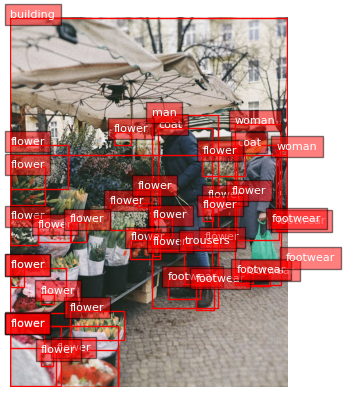

In [ ]:
plot_bbox(img1, results1['<OD>']);

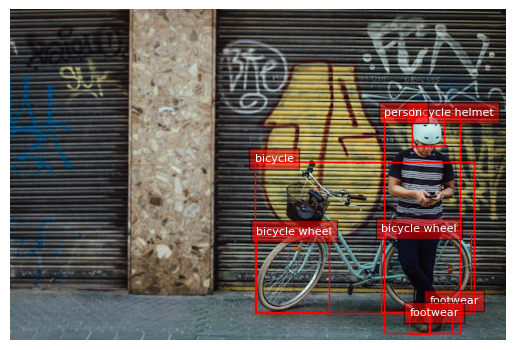

In [ ]:
results2 = generate_labels(task_prompt3, img2)

plot_bbox(img2, results2['<OD>']);

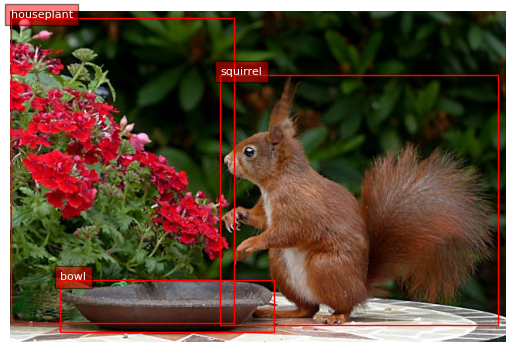

In [ ]:
results3 = generate_labels(task_prompt3, img3)

plot_bbox(img3, results3['<OD>']);

# Task 4 - Guided object detection

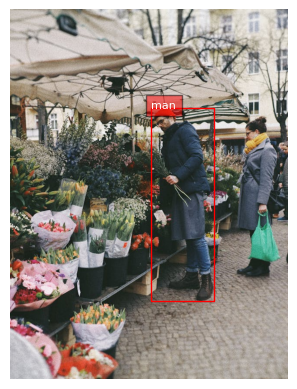

In [ ]:
task_prompt4 = "<CAPTION_TO_PHRASE_GROUNDING>"

results1 = generate_labels(task_prompt4, img1, text_input="man")

plot_bbox(img1, results1['<CAPTION_TO_PHRASE_GROUNDING>']);

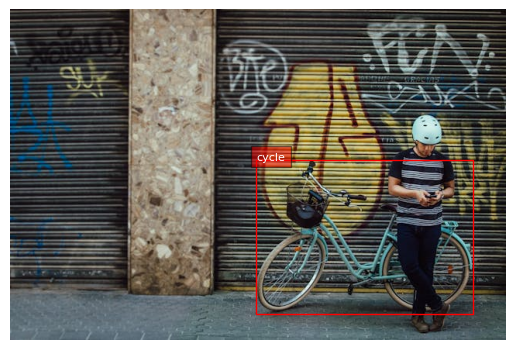

In [ ]:
task_prompt4 = "<CAPTION_TO_PHRASE_GROUNDING>"

results2 = generate_labels(task_prompt4, img2, text_input="cycle")

plot_bbox(img2, results2['<CAPTION_TO_PHRASE_GROUNDING>']);